# Maverik Modeling
## Heber Jenson

## Notebook Summary

This notebook is designed to provide the modeling aproach used to predict four target variables, total daily gallons unleaded gasoline sold, total daily gallons diesel sold, total daily inside sales, and total daily food sales. Data was provided by Maverik and gas station franchise company that wants to estimate these target metrics daily over the course of the first year a store Is open.

The notebook walks you through the steps I have taken to import the data, split the data into train and test sets, and use five different models to try the most accurate prediction for the target variables. All models were compared to the average daily results of the training data set. This was the baseline to beat.

Most models, as you will see, did not perform well. LSTM did perform well, but there are concerns that overfitting may occur.

## Table of Contents:
* Initial Set Up
* View the target variables
* Split data in train and test
* Set up models to test
* Initial Testing
* Summary Results

## Initial Set Up

In [1]:
# Import packages
import numpy as np
import math
import os
import pandas as pd
import sklearn as sk
import matplotlib
import seaborn as sns
from datetime import datetime, timedelta, date
import holidays
import calendar
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
!pip install prophet
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
# from keras.models import Sequential
# from keras.layers import Dense
from tensorflow.keras.models import load_model
# from keras.layers import LSTM
import tensorflow as tf

import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import plotly.express as px
import warnings

In [2]:
# mount colab to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set seed
tf.random.set_seed(1234)
np.random.seed(1234)

# Remove Warnings
warnings.filterwarnings('ignore')

### Load Data

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Master's Program/Capstone/Final_Maverik_Data.csv") # Upload Data from EDA
avg_ests = pd.read_csv("/content/drive/MyDrive/Master's Program/Capstone/Average_Value_Estimates.csv") # Baseline for model comparison

Ave_ests data is the average take for each target variable from the training data set. To address the time difference when each store opened, the average was taken using the number of days from the store opening. This data will be used for the model baseline to beat as we do not have access to the performance metrics of Maverik's current model.

### Quick view of the data

In [5]:
data.head()

,Unnamed: 0,open_year,square_feet,years_since_last_project,parking_spaces,x1_mile_pop,x1_mile_emp,x1_mile_income,x1_2_mile_pop,x1_2_mile_emp,...,Holidays_Martin Luther King Jr. Day,Holidays_Memorial Day,Holidays_New Year's Day,Holidays_New Year's Day (Observed),Holidays_Not Holiday,Holidays_Thanksgiving,Holidays_Veterans Day,Holidays_Washington's Birthday,soft_opening_date,calendar_day_date
0,0,2021,5046,2,38,4046,3648,43435,556,642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1/12/2021,2021-01-17
1,1,2021,5046,2,38,4046,3648,43435,556,642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1/12/2021,2021-01-20
2,2,2021,5046,2,38,4046,3648,43435,556,642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1/12/2021,2021-01-21
3,3,2021,5046,2,38,4046,3648,43435,556,642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1/12/2021,2021-01-24
4,4,2021,5046,2,38,4046,3648,43435,556,642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1/12/2021,2021-01-29


In [6]:
for col in data:
  print('\'{}\','.format(col))

'Unnamed: 0',
'open_year',
'square_feet',
'years_since_last_project',
'parking_spaces',
'x1_mile_pop',
'x1_mile_emp',
'x1_mile_income',
'x1_2_mile_pop',
'x1_2_mile_emp',
'x1_2_mile_income',
'x5_min_pop',
'x5_min_emp',
'x5_min_inc',
'x7_min_pop',
'x7_min_emp',
'x7_min_inc',
'traditional_forecourt_fueling_positions',
'rv_lanes_fueling_positions',
'hi_flow_lanes_fueling_positions',
'hi_flow_lanes_fueling_positions_2',
'rv_lanes_fueling_positions_2',
'mens_toilet_count',
'mens_urinal_count',
'womens_toilet_count',
'womens_sink_count',
'site_id_msba',
'calendar.fiscal_week_id_for_year',
'daily_yoy_ndt.total_inside_sales',
'daily_yoy_ndt.total_food_service',
'diesel_y',
'unleaded',
'Crude Oil Cushing, OK WTI Spot Price FOB (Dollars per Barrel)',
'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
'U.S. Gulf Coast Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)'

For simplicity, we are going to drop the categorical data, tempature data, and oil price data. This means that the data use for predictions will be limited to quantitative data. For future analysis, Maverik may want to pursue additional efforts to explore these variables.

In [7]:
data['calendar_day_date'] = pd.to_datetime(data['calendar_day_date'])
data = data.drop(['open_year', 'Crude Oil Cushing, OK WTI Spot Price FOB (Dollars per Barrel)',
'New York Harbor Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
'U.S. Gulf Coast Conventional Gasoline Regular Spot Price FOB (Dollars per Gallon)',
'Los Angeles Reformulated RBOB Regular Gasoline Spot Price (Dollars per Gallon)',
'New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
'U.S. Gulf Coast Ultra-Low Sulfur No 2 Diesel Spot Price (Dollars per Gallon)',
'Los Angeles, CA Ultra-Low Sulfur CARB Diesel Spot Price (Dollars per Gallon)',
'Utah', 'Idaho', 'Oregon', 'South Dakota', 'Nebraska', 'New Mexico', 'Washington', 'Arizona', 'Colorado', 'Nevada',
'Wyoming','W. Monthly Average Temp', 'square_feet',
'years_since_last_project',
'parking_spaces',
'x1_mile_pop',
'x1_mile_emp',
'x1_mile_income',
'x1_2_mile_pop',
'x1_2_mile_emp',
'x1_2_mile_income',
'x5_min_pop',
'x5_min_emp',
'x5_min_inc',
'x7_min_pop',
'x7_min_emp',
'x7_min_inc',
'traditional_forecourt_fueling_positions',
'rv_lanes_fueling_positions',
'hi_flow_lanes_fueling_positions',
'hi_flow_lanes_fueling_positions_2',
'rv_lanes_fueling_positions_2',
'mens_toilet_count',
'mens_urinal_count',
'womens_toilet_count',
'womens_sink_count',
'lottery_Yes',
'freal_Yes',
'bonfire_grill_Yes',
'pizza_Yes',
'cinnabon_Yes',
'ethanol_free_Yes',
'hi_flow_lanes_Yes',
'rv_lanes_Yes',
'hi_flow_rv_lanes_Yes',
'def_Yes',
'cat_scales_Yes',
'rv_dumps_Yes',
'propane_Yes',
'traditional_forecourt_layout_Stack',
'traditional_forecourt_stack_type_Large',
'traditional_forecourt_stack_type_None',
'rv_lanes_layout_None',
'rv_lanes_layout_Stack',
'rv_lanes_stack_type_None',
'hi_flow_lanes_layout_None',
'hi_flow_lanes_layout_Stack',
'hi_flow_lanes_stack_type_None',
'hi_flow_rv_lanes_layout_In-Line',
'hi_flow_rv_lanes_layout_None',
'hi_flow_rv_lanes_layout_Stack',
'hi_flow_rv_lanes_stack_type_None',], axis=1)

In [8]:
data.rename(columns={'diesel_y': 'diesel', 'daily_yoy_ndt.total_inside_sales': 'inside_sales',
                     'daily_yoy_ndt.total_food_service': 'food_sales', 'calendar_day_date': 'date'}, inplace=True)

In [9]:
data['Week_of_year'] = data['calendar.fiscal_week_id_for_year']
data = data.drop('calendar.fiscal_week_id_for_year', axis = 1)

In [10]:
data['Week_of_year'].head()

0    3
1    3
2    3
3    4
4    5
Name: Week_of_year, dtype: int64

### View Target Variables

In [11]:
a = data.set_index("date").groupby("site_id_msba").resample("D").diesel.sum().reset_index()
px.line(a, x = "date", y= "diesel", color = "site_id_msba", title = "Daily Diesel Quantity Sold by Store")

Store site 21980 may be an outlier for the amount of diesel they sell daily. This could pose a challenge for the models to try and predict this or may create issues if this data point is used as the training set. For now we will keep it in the data.

In [12]:
a = data.set_index("date").groupby("site_id_msba").resample("D").unleaded.sum().reset_index()
px.line(a, x = "date", y= "unleaded", color = "site_id_msba", title = "Daily Unleaded Quantity Sold by Store")

Store site 22260 may be an outlier for the amount of unleaded they sell daily. This could pose a challenge for the models to try and predict this or may create issues if this data point is used as the training set. For now we will keep it in the data.

In [13]:
a = data.set_index("date").groupby("site_id_msba").resample("D")['food_sales'].sum().reset_index()
px.line(a, x = "date", y= "food_sales", color = "site_id_msba", title = "Daily Food Sales by Store")

Store site 22085 may be an outlier for the amount of food they sell daily. This could pose a challenge for the models to try and predict this or may create issues if this data point is used as the training set. For now we will keep it in the data.

In [14]:
a = data.set_index("date").groupby("site_id_msba").resample("D")['inside_sales'].sum().reset_index()
px.line(a, x = "date", y= "inside_sales", color = "site_id_msba", title = "Daily Inside Sales by Store")

Store site 22085 may be an outlier for daily inside sales. This could pose a challenge for the models to try and predict this or may create issues if this data point is used as the training set. For now we will keep it in the data.

In [15]:
data = data.drop('Unnamed: 0', axis=1)
data = data.sort_values(by = ['site_id_msba', 'date'], ascending = [False, False])
data['site_id_msba'].unique()

array([24535, 24255, 24220, 24150, 23905, 23835, 23765, 23730, 23660,
       23555, 23485, 23450, 23415, 23380, 23345, 23240, 23135, 22925,
       22890, 22855, 22820, 22785, 22750, 22715, 22680, 22645, 22575,
       22540, 22505, 22400, 22330, 22260, 22120, 22085, 22015, 21980,
       21560])

## Split data into train and test:
Data should be split into train & test based on random store_id.

In [16]:
from numpy.lib.arraysetops import isin
sites_test = np.random.choice(data['site_id_msba'].unique(), 30, replace = False)
print(sites_test)
test = data.loc[-data['site_id_msba'].isin(sites_test)]
train = data.loc[data['site_id_msba'].isin(sites_test)]

[23660 21560 23345 24255 23905 22400 22820 22925 23380 22785 24535 23730
 24150 23485 23765 24220 22120 22505 22540 22890 22085 22260 22645 23835
 23135 22015 22750 22330 21980 23450]


In [17]:
train_sites = train['site_id_msba'].unique()
train_sites

array([24535, 24255, 24220, 24150, 23905, 23835, 23765, 23730, 23660,
       23485, 23450, 23380, 23345, 23135, 22925, 22890, 22820, 22785,
       22750, 22645, 22540, 22505, 22400, 22330, 22260, 22120, 22085,
       22015, 21980, 21560])

In [18]:
test_sites = test['site_id_msba'].unique()
test_sites

array([23555, 23415, 23240, 22855, 22715, 22680, 22575])

We need to now split data into specific site ids for model training and testing.

In [19]:
train_d = {site: train[train['site_id_msba'] == site] for site in train_sites}
test_d = {site: test[test['site_id_msba'] == site] for site in test_sites}

In [20]:
for site in train_d:
  train_d[site] = train_d[site].sort_values(by= 'date', ascending = True) # .set_index('date')

for site in test_d:
  test_d[site] = test_d[site].sort_values(by= 'date', ascending = True) # .set_index('date')

Split Average Test Data Into target varibales

In [21]:
avg_est_d = avg_ests['Average_diesel']
avg_est_u = avg_ests['Average_unleaded']
avg_est_i = avg_ests['Average_inside_sales']
avg_est_f = avg_ests['Average_food_sales']

In [22]:
train_d[24535].head()

,site_id_msba,inside_sales,food_sales,diesel,unleaded,calendar.day_of_week_Monday,calendar.day_of_week_Saturday,calendar.day_of_week_Sunday,calendar.day_of_week_Thursday,calendar.day_of_week_Tuesday,...,Holidays_Memorial Day,Holidays_New Year's Day,Holidays_New Year's Day (Observed),Holidays_Not Holiday,Holidays_Thanksgiving,Holidays_Veterans Day,Holidays_Washington's Birthday,soft_opening_date,date,Week_of_year
13453,24535,1298.3355,552.1740,200.6830,847.1085,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6/14/2022,2022-06-14,24
13274,24535,1631.6825,764.1585,424.3540,1149.5190,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6/14/2022,2022-06-15,24
13454,24535,2107.3500,883.7290,817.9360,1237.7750,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6/14/2022,2022-06-16,24
13176,24535,2168.2920,861.6930,722.7745,1425.1020,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6/14/2022,2022-06-17,25
13455,24535,1660.1200,668.8220,397.2325,774.6865,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6/14/2022,2022-06-18,25


## Models to Test:
* Averages from Training Data Sets
* ARIMA
* SARIMA
* Exponential Smoothing
* XGBoost
* Neural Network (LSTM)

Code used to create all four target variable train and test sets.

In [23]:
def np_float_covert(df):
  for i in df:
    if df[i].dtype == 'object':
      continue
    else:
      df[i] == df[i].astype(np.float32, inplace=True)
  return df

In [24]:
def single_site_train(df_train_site):

  # Create training sets for each target variable
  train_diesel = df_train_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'food_sales', 'unleaded'], axis = 1)
  train_unleaded = df_train_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'food_sales', 'diesel'], axis = 1)
  train_food = df_train_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'diesel', 'unleaded'], axis = 1)
  train_inside = df_train_site.drop(['site_id_msba', 'soft_opening_date', 'food_sales', 'diesel', 'unleaded'], axis = 1)
  return train_diesel, train_unleaded, train_food, train_inside

In [25]:
def single_site_test(df_test_site):

  # Create test sets for each target variable
  test_diesel = df_test_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'food_sales', 'unleaded'], axis = 1)
  test_unleaded = df_test_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'food_sales', 'diesel'], axis = 1)
  test_food = df_test_site.drop(['site_id_msba', 'soft_opening_date', 'inside_sales', 'diesel', 'unleaded'], axis = 1)
  test_inside = df_test_site.drop(['site_id_msba', 'soft_opening_date', 'food_sales', 'diesel', 'unleaded'], axis = 1)
  return test_diesel, test_unleaded, test_food, test_inside

Code used to train, test, and generate performance stats for the five models we are testing.

In [26]:
def train_models(df_train_site_target, target_var, train_site):
  # ARIMA Model
  arima_model = ARIMA(df_train_site_target[target_var], order=(5, 1, 0))
  arima_model_fit = arima_model.fit()

  # SARIMA Model
  sarima_model = SARIMAX(df_train_site_target[target_var], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
  sarima_model_fit = sarima_model.fit(disp=0)

  # Prophet Model
  # prophet_model = Prophet()
  # prophet_model_fit = prophet_model.fit(df_train_site_target[['date', target_var]].rename(columns={'date': 'ds', target_var: 'y'}))

  # Exponential Smoothing Model (ETS)
  ets_model = ExponentialSmoothing(df_train_site_target[target_var], seasonal='add', seasonal_periods=12)
  ets_model_fit = ets_model.fit()

  # XGBoost Model
  xgb_model = xgb.XGBRegressor()
  xgb_model_fit = xgb_model.fit(df_train_site_target.index.values.reshape(-1, 1), df_train_site_target[target_var])


  # Neural Network Model (using LSTM)
  def create_lstm_model():
      model = Sequential()

      model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
      model.add(Dense(1))
      model.compile(optimizer='adam', loss='mean_squared_error')
      return model

  # Reshape the data for LSTM
  X_train = df_train_site_target[target_var].values.reshape(-1, 1, 1)

  lstm_model = create_lstm_model()
  lstm_model.fit(X_train, df_train_site_target[target_var], epochs=100, batch_size=1, verbose=0)
  lstm_model.save(f"/content/drive/MyDrive/Master's Program/Capstone/LSTM_Mods/lstm_{target_var}_model_{train_site}.h5")

  return arima_model_fit, sarima_model_fit, ets_model_fit, xgb_model_fit, lstm_model

In [27]:
def test_models(train, test, target, avg_est, train_site):
  # Creating trained models
  a_m, s_m, ets_m, xgb_m, lstm_m = train_models(train, target, train_site)



  forecast_periods = 366
  X_test = test[target].values.reshape(-1, 1, 1)
  print(X_test[0])

  # Predict using the trained models
  arima_forecast = a_m.forecast(forecast_periods)
  sarima_forecast = s_m.forecast(forecast_periods)
  # prophet_forecast = pro_m.predict(test[['date']].rename(columns={'date': 'ds'}))
  ets_forecast = ets_m.forecast(forecast_periods)
  xgb_forecast = xgb_m.predict(test.index.values.reshape(-1, 1))
  lstm_forecast = lstm_m.predict(X_test)

  # Plot the forecasts
  plt.figure(figsize=(12, 6))
  plt.plot(test['date'], test[target], label='Actual', color = 'dimgrey')
  plt.plot(test['date'], avg_est, label='Avg_est', color = 'cyan')
  plt.plot(test['date'], arima_forecast, label='ARIMA Forecast', color = 'yellow')
  plt.plot(test['date'], sarima_forecast, label='SARIMA Forecast', color = 'purple')
  # # plt.plot(test['date'], prophet_forecast[-len(test):]['yhat'], label='Prophet Forecast')
  plt.plot(test['date'], ets_forecast, label='ETS Forecast', color = 'green')
  plt.plot(test['date'], xgb_forecast, label='XGBoost Forecast', color = 'blue')
  plt.plot(test['date'], lstm_forecast, label='LSTM Forecast', color = 'red')
  plt.legend()
  plt.title('{} Forecasting'.format(target))
  plt.xlabel('Date')
  plt.ylabel('{}'.format(target))
  plt.show()

  true_values = test[target].values

  print(true_values[0])

  # Calculate RMSE for each model's forecast
  train_data_avg = round(np.sqrt(mean_squared_error(true_values, avg_est)), 2)
  arima_rmse = round(np.sqrt(mean_squared_error(true_values, arima_forecast)), 2)
  sarima_rmse = round(np.sqrt(mean_squared_error(true_values, sarima_forecast)), 2)
  # prophet_rmse = np.sqrt(mean_squared_error(true_values, prophet_forecast[-len(true_values):]['yhat']))
  ets_rmse = round(np.sqrt(mean_squared_error(true_values, ets_forecast)), 2)
  xgb_rmse = round(np.sqrt(mean_squared_error(true_values, xgb_forecast)), 2)
  lstm_rmse = round(np.sqrt(mean_squared_error(true_values, lstm_forecast)), 2)

  # Output RMSE for each model
  print(f"Avg_Est RMSE: {train_data_avg}")
  print(f"ARIMA RMSE: {arima_rmse}")
  print(f"SARIMA RMSE: {sarima_rmse}")
  # print(f"Prophet RMSE: {prophet_rmse}")
  print(f"ETS RMSE: {ets_rmse}")
  print(f"XGBoost RMSE: {xgb_rmse}")
  print(f"LSTM RMSE: {lstm_rmse}")


Code used for LSTM Models.

In [28]:
# def train_lstm_models(df_train_site_target, target_var, train_site, test_site):

#   # Neural Network Model (using LSTM)
#   def create_lstm_model():
#       model = Sequential()
#       model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
#       model.add(Dense(1))
#       model.compile(optimizer='adam', loss='mean_squared_error')
#       return model

#   # Reshape the data for LSTM
#   X_train = df_train_site_target[target_var].values.reshape(-1, 1, 1)

#   lstm_model = create_lstm_model()
#   lstm_model.fit(X_train, df_train_site_target[target_var], epochs=100, batch_size=1, verbose=0)
#   lstm_model.save(f"lstm_{target_var}_model_{train_site}_{test_site}.keras")
#   print(f"{target_var}_model_{train_site}_{test_site}")

#   return lstm_model

In [29]:
def train_lstm_models(df_train_site_target, target_var, train_site, test_site):
    # Check and convert data types
    df_train_site_target[target_var] = pd.to_numeric(df_train_site_target[target_var], errors='coerce')
    df_train_site_target = df_train_site_target.drop('date', axis=1)

    # Check for missing values
    if df_train_site_target.isnull().values.any():
        raise ValueError("Missing values detected. Handle missing values in your data.")

    # Neural Network Model (using LSTM)
    def create_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=input_shape))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Reshape the data for LSTM
    n_steps = 366
    n_features = 23

    X_train = df_train_site_target.drop(columns=[target_var]).values.reshape(-1, n_steps, n_features)
    y_train = df_train_site_target[target_var].values.reshape(-1, n_steps)

    input_shape = (n_steps, n_features)

    lstm_model = create_lstm_model(input_shape)
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

    # Save only the weights
    model_filename = f"lstm_{target_var}_model_{train_site}_{test_site}.h5"
    lstm_model.save_weights(model_filename)
    print(f"Saved weights to {model_filename}")

    return lstm_model


In [30]:
def all_lstm_mod_train(train_site_data_dict, test_site_dict, avg_est):
  train_sites = train_site_data_dict.keys()
  test_sites = test_site_dict.keys()
  target_array = ['diesel', 'unleaded', 'food_sales', 'inside_sales']

  for train_site in train_sites: # Iterate through train_sites
    train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_site_data_dict[train_site]) # obtain training site target variables
    train_target_data = [train_diesel, train_unleaded, train_food, train_inside]

    for test_site in test_sites: # Iterate through test_sites
      test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_site_dict[test_site])
      test_target_data = [test_diesel, test_unleaded, test_food, test_inside] # obtain testing site target variables

      for i in range(len(target_array)): # Iterate through target variables
        test_lstm_model(train_target_data[i], test_target_data[i], target_array[i], avg_est, train_site, test_site)


Code used to make daily predictions for store site.

In [31]:
def run_daily_predictions(train, test, target, avg_est, train_site, test_site):
  a_m, s_m, ets_m, xgb_m, lstm_m = train_models(train, target, train_site)

  forecast_periods = 366


  # lstm_model.load_model(f"/content/drive/MyDrive/Master's Program/Capstone/LSTM_Mods/lstm_{target_var}_model_{train_site}.h5")

  for row in range(367):
    X_test = test[target].values[:row+1].reshape(-1, 1, 1)

    lstm_forecast = lstm_m.predict(X_test)

    true_values = test[target].values

    # Calculate RMSE for each model's forecast
    train_data_avg = np.sqrt(mean_squared_error(true_values, avg_est))
    lstm_rmse = np.sqrt(mean_squared_error(true_values, lstm_forecast))

    # Output RMSE for each model
    print(f"Avg_Est RMSE: {train_data_avg}")
    print(f"LSTM RMSE: {lstm_rmse}")

### Initial model performance based on single site from test and train tests.

[[80.7135]]
12/12 [==============================] - 0s 3ms/step


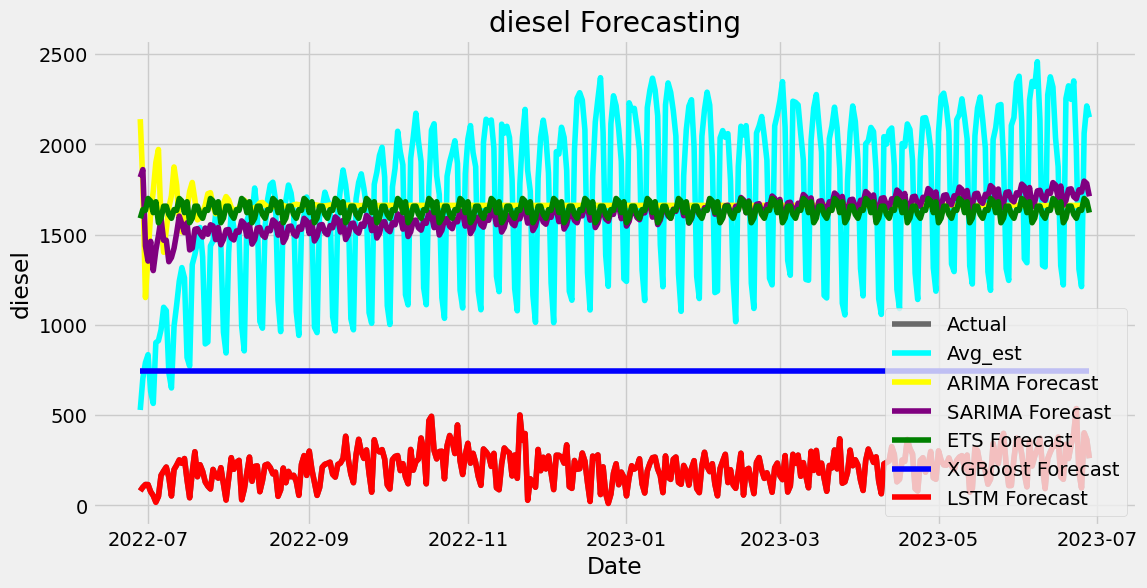

80.7135
Avg_Est RMSE: 1548.92
ARIMA RMSE: 1455.74
SARIMA RMSE: 1407.08
ETS RMSE: 1429.62
XGBoost RMSE: 543.45
LSTM RMSE: 0.45


In [32]:
train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_d[24535])
test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_d[23555])

test_models(train_diesel, test_diesel, 'diesel', avg_est_d, 24535)

Initial modeling performance is showing improvement over the average value for the target data. LSTM is performing so well; there are concerns about how it is doing so well.

[[80.7135]]
12/12 [==============================] - 0s 2ms/step


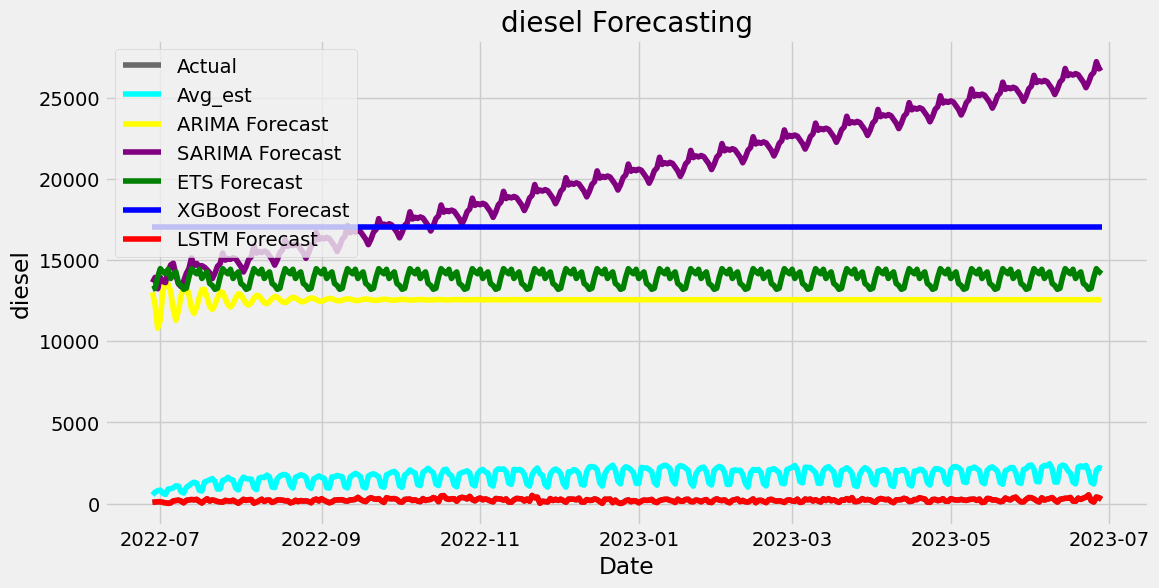

80.7135
Avg_Est RMSE: 1548.92
ARIMA RMSE: 12340.16
SARIMA RMSE: 20323.33
ETS RMSE: 13707.39
XGBoost RMSE: 16819.23
LSTM RMSE: 1.42


In [33]:
# Run models on potential outlier
train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_d[21980])
test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_d[23555])

test_models(train_diesel, test_diesel, 'diesel', avg_est_d, 21980)

LSTM model still performs extremely well even when trained on the model that seems to be an outlier site for the deisel target varable.

[[605.486]]
12/12 [==============================] - 0s 2ms/step


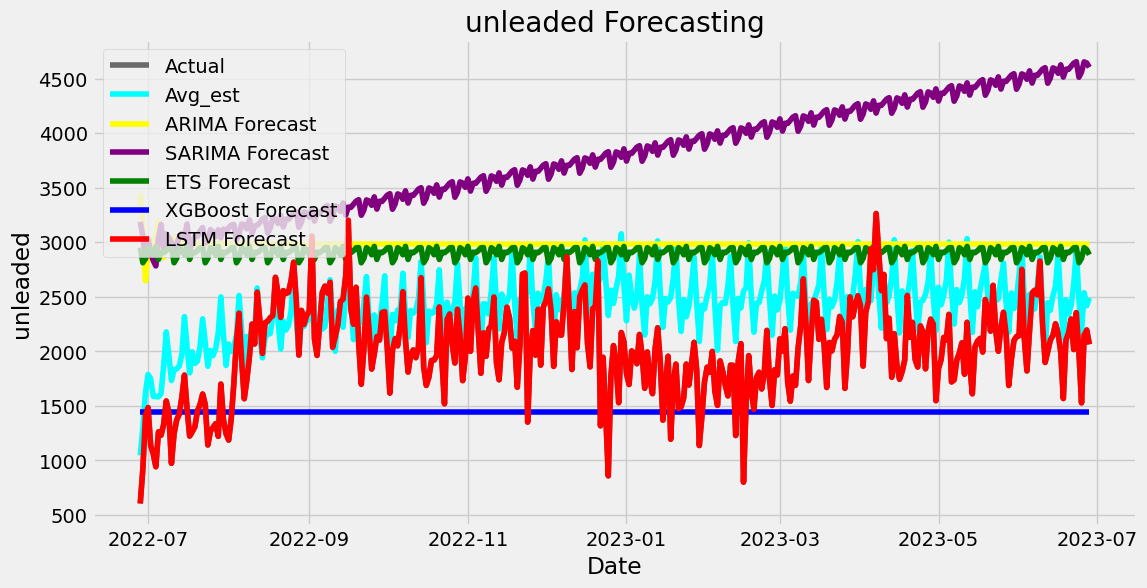

605.486
Avg_Est RMSE: 526.62
ARIMA RMSE: 1059.54
SARIMA RMSE: 1865.63
ETS RMSE: 986.9
XGBoost RMSE: 705.08
LSTM RMSE: 0.81


In [34]:
train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_d[24535])
test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_d[23555])

test_models(train_unleaded, test_unleaded, 'unleaded', avg_est_u, 24535)

Initial modeling performance is not doing well for Arima, Sarima, ETS, & XGBoost. All models with the expectation of LSTM are above the Ave_est performance baseline. LSTM is performing so well; there are concerns about how it is doing so well.

[[198.8805]]
12/12 [==============================] - 0s 2ms/step


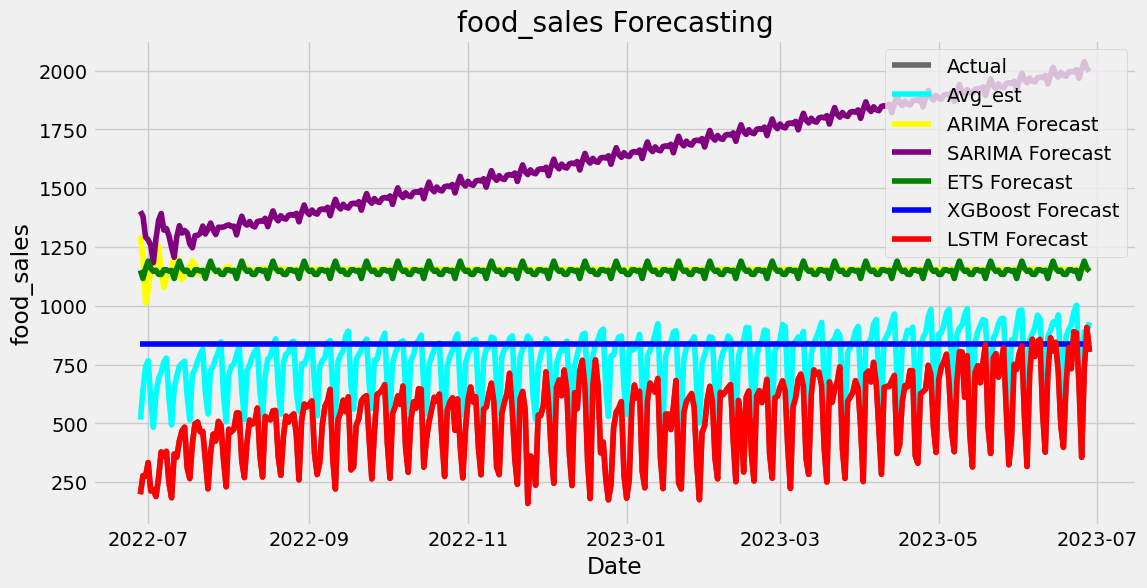

198.8805
Avg_Est RMSE: 258.62
ARIMA RMSE: 653.34
SARIMA RMSE: 1130.26
ETS RMSE: 647.16
XGBoost RMSE: 355.45
LSTM RMSE: 0.02


In [35]:
train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_d[24535])
test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_d[23555])

test_models(train_food, test_food, 'food_sales', avg_est_f, 24535)

Initial modeling performance is not doing well for Arima, Sarima, ETS, & XGBoost. All models with the expectation of LSTM are above the Ave_est performance baseline. LSTM is performing so well; there are concerns about how it is doing so well.

[[1057.1925]]
12/12 [==============================] - 0s 2ms/step


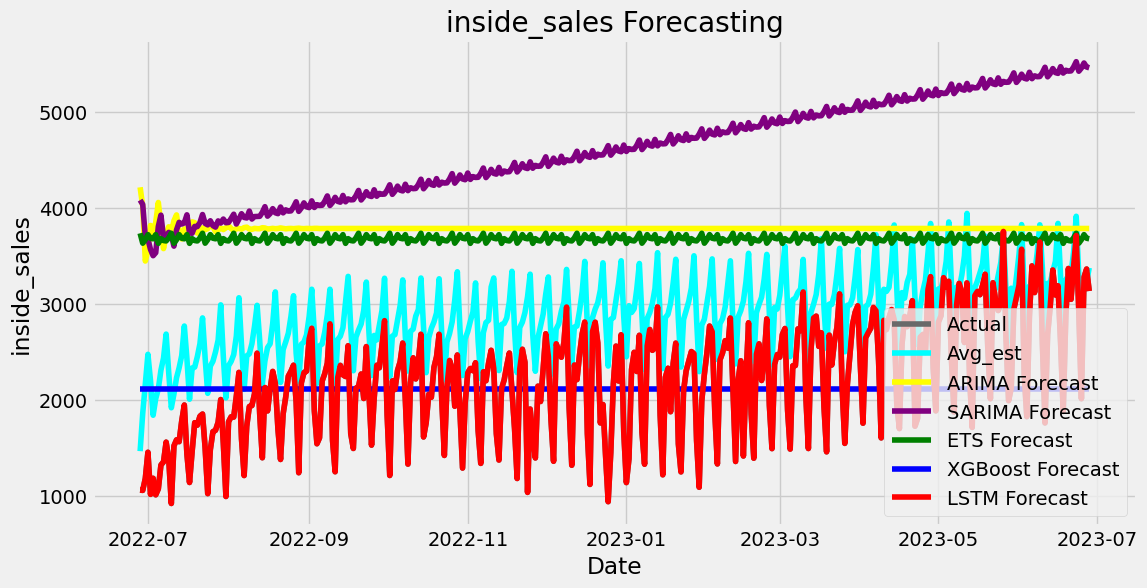

1057.1925
Avg_Est RMSE: 737.2
ARIMA RMSE: 1673.19
SARIMA RMSE: 2423.92
ETS RMSE: 1573.02
XGBoost RMSE: 611.37
LSTM RMSE: 0.08


In [36]:
train_diesel, train_unleaded, train_food, train_inside = single_site_train(train_d[24535])
test_diesel, test_unleaded, test_food, test_inside = single_site_test(test_d[23555])

test_models(train_inside, test_inside, 'inside_sales', avg_est_i, 24535)

Initial modeling performance is not doing well for Arima, Sarima, & ETS. XGBoost did beat the baseline performance metric, but that may only be for this one particular site. All models with the expectation of LSTM are above the Ave_est performance baseline. LSTM is performing so well; there are concerns about how it is doing so well.

### Code to create future predictions on a new site.




In [42]:
def days_of_week(day_number): # Used to generate values for days of week from date value.
    if day_number == 0:
        return {'Monday' : 1, 'Saturday' : 0, 'Sunday' : 0, 'Thursday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Weekend' : 0}
    elif day_number == 1:
        return {'Monday' : 0, 'Saturday' : 0, 'Sunday' : 0, 'Thursday' : 0, 'Tuesday' : 1, 'Wednesday' : 0, 'Weekend' : 0}
    elif day_number == 2:
        return {'Monday' : 0, 'Saturday' : 0, 'Sunday' : 0, 'Thursday' : 0, 'Tuesday' : 0, 'Wednesday' : 1, 'Weekend' : 0}
    elif day_number == 3:
        return {'Monday' : 0, 'Saturday' : 0, 'Sunday' : 0, 'Thursday' : 1, 'Tuesday' : 0, 'Wednesday' : 0, 'Weekend' : 0}
    elif day_number == 4:
        return {'Monday' : 0, 'Saturday' : 0, 'Sunday' : 0, 'Thursday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Weekend' : 0}
    elif day_number == 5:
        return {'Monday' : 0, 'Saturday' : 1, 'Sunday' : 0, 'Thursday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Weekend' : 1}
    elif day_number == 6:
        return {'Monday' : 0, 'Saturday' : 0, 'Sunday' : 1, 'Thursday' : 0, 'Tuesday' : 0, 'Wednesday' : 0, 'Weekend' : 1}
    else:
        print("Invalid day number")

In [43]:
def fed_holidays(date_val): # Used to generate values for federal holidays contained in the training data set. This will need to be adjusted for future years.
    holiday = holidays.UnitedStates()

    if holiday.get(date_val) == 'Christmas Day (Observed)':
        return {'Holidays_Christmas Day (Observed)' : 1, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) =='Columbus Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 1, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Independence Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 1, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Independence Day (Observed)':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 1,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Juneteenth National Independence Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 1, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Juneteenth National Independence Day (Observed)':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 1,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Labor Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 1, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Martin Luther King Jr. Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 1, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Memorial Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 1, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'New Year\'s Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 1,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'New Year\'s Day (Observed)':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 1, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Not Holiday':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 1, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Thanksgiving':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 1, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Veterans Day':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 1,
                'Holidays_Washington\'s Birthday':0}
    elif holiday.get(date_val) == 'Washington\'s Birthday':
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':1}
    else:
        return {'Holidays_Christmas Day (Observed)' : 0, 'Holidays_Columbus Day': 0, 'Holidays_Independence Day': 0, 'Holidays_Independence Day (Observed)': 0,
                'Holidays_Juneteenth National Independence Day': 0, 'Holidays_Juneteenth National Independence Day (Observed)': 0,
                'Holidays_Labor Day': 0, 'Holidays_Martin Luther King Jr. Day': 0, 'Holidays_Memorial Day' : 0, 'Holidays_New Year\'s Day' : 0,
                'Holidays_New Year\'s Day (Observed)': 0, 'Holidays_Not Holiday': 0, 'Holidays_Thanksgiving': 0, 'Holidays_Veterans Day': 0,
                'Holidays_Washington\'s Birthday':0}

In [44]:
def dates_generator(store_open_date): # Creates dataframe for new dates from the start of a new store's opening date.
  data = pd.DataFrame({'Monday' : [], 'Saturday' : [], 'Sunday' : [],'Thursday' : [], 'Tuesday' : [], 'Wednesday' : [], 'Weekend' : [],'Holidays_Christmas Day (Observed)': [],
'Holidays_Columbus Day': [], 'Holidays_Independence Day': [], 'Holidays_Independence Day (Observed)': [], 'Holidays_Juneteenth National Independence Day': [],
'Holidays_Juneteenth National Independence Day (Observed)': [], 'Holidays_Labor Day': [], 'Holidays_Martin Luther King Jr. Day': [], 'Holidays_Memorial Day': [], 'Holidays_New Year\'s Day': [],
'Holidays_New Year\'s Day (Observed)': [], 'Holidays_Not Holiday': [], 'Holidays_Thanksgiving': [], 'Holidays_Veterans Day': [], 'Holidays_Washington\'s Birthday': [], 'date' : [], 'Week_of_year' : []})

  start_date = datetime.strptime(store_open_date, '%m-%d-%Y').date()


  for day in range(366):
    week = start_date.isocalendar()[1]
    day = start_date.weekday()
    row = days_of_week(day)
    a2 = fed_holidays(start_date)
    a3 = {'date' : start_date, 'Week_of_year' : week, 'target': np.random.random_integers(0, 3000)}


    row.update(a2)
    row.update(a3)
    row = pd.DataFrame(row, index = [day])


    data = pd.concat([data, row], ignore_index=True)
    data.reset_index()

    start_date = start_date + timedelta(days=1)


  return data

In [45]:
# Create new data set base on start date:
testdates = dates_generator('11-7-2023')
testdates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 25 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Monday                                                    366 non-null    float64
 1   Saturday                                                  366 non-null    float64
 2   Sunday                                                    366 non-null    float64
 3   Thursday                                                  366 non-null    float64
 4   Tuesday                                                   366 non-null    float64
 5   Wednesday                                                 366 non-null    float64
 6   Weekend                                                   366 non-null    float64
 7   Holidays_Christmas Day (Observed)                         366 non-null    float64
 8   Holidays_Columbus Da

In [46]:
def test_lstm_model_new_site(train_df, test_df, target, train_site, avg_est):
  # Creating trained models
  lstm_m = train_lstm_models(train_df, target, train_site, 1234)

  test_df = test_df.drop('date', axis=1)

  # Reshape the data for LSTM
  n_steps = 366
  n_features = 23

  X_test = test_df.drop(columns=['target']).values.reshape(-1, n_steps, n_features)

  # Predict using the trained models
  lstm_forecast = lstm_m.predict(X_test)

  # # Plot the forecasts
  # plt.figure(figsize=(12, 6))
  # # plt.plot(test_df['date'], test[target], label='Actual', color = 'dimgrey')
  # plt.plot(test_df['date'], avg_est, label='Avg_est', color = 'cyan')
  # plt.plot(test_df['date'], lstm_forecast, label='LSTM Forecast', color = 'red')
  # plt.legend()
  # plt.title('{} Forecasting'.format(target))
  # plt.xlabel('Date')
  # plt.ylabel('{}'.format(target))
  # plt.show()

  for i in range(len(lstm_forecast)):
    print(f"Day: {i} Target: {target}, Prediction: {lstm_forecast[i]}, Actual: {test_df['target'][i]}, Error: {test_df['target'][i] - lstm_forecast[i]}")

## Results Summary:

Maverik assigned us to develop a model capable of predicting future store values of four target variables. In this notebook, six models were applied to the data set to determine which would be the best for Maverik to use. Of the six, LSTM was the best performing, getting incredibly accurate predictions compared to the training data. Most of the other models failed to beat the benchmark of the average values of the training set when taken from days after opening.

Moving forward we would reccomend Maverik use the LSTM model for future predictions. This would allow them to better prepare for the first year sales of new stores opening in the future and quickly identify any stores that may be under performing inital estimates.
